# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Name 1
* Name 2
* Name 3

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [1]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.6.1
nltk's version: 3.9.1
pandas's version: 2.2.3


[nltk_data] Downloading package punkt to /home/petko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [18]:
DATA = Path("data")

TEXT_P = Path("texts")

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [20]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [23]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000000511,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,mythology,0
mythology.stackexchange_0000004862,Q:\n\nDoes Scotland have any discrete mytholog...,mythology,0
mythology.stackexchange_0000003400,Q:\n\nWhat is the earliest story of summoning ...,mythology,0
mythology.stackexchange_0000001484,Q:\n\nHow did Helen get back from Troy?\n\nThe...,mythology,0
mythology.stackexchange_0000005938,Q:\n\nWhat source makes the claim that Melanip...,mythology,0
...,...,...,...
portuguese.stackexchange_0000000168,Q:\n\nConserto ou Concerto?\n\nÉ visto constan...,portuguese,5
portuguese.stackexchange_0000009583,Q:\n\nUso do ponto e vírgula no lugar de dois-...,portuguese,5
portuguese.stackexchange_0000006412,"Q:\n\nQual é a diferença no uso de ""reparar"" e...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

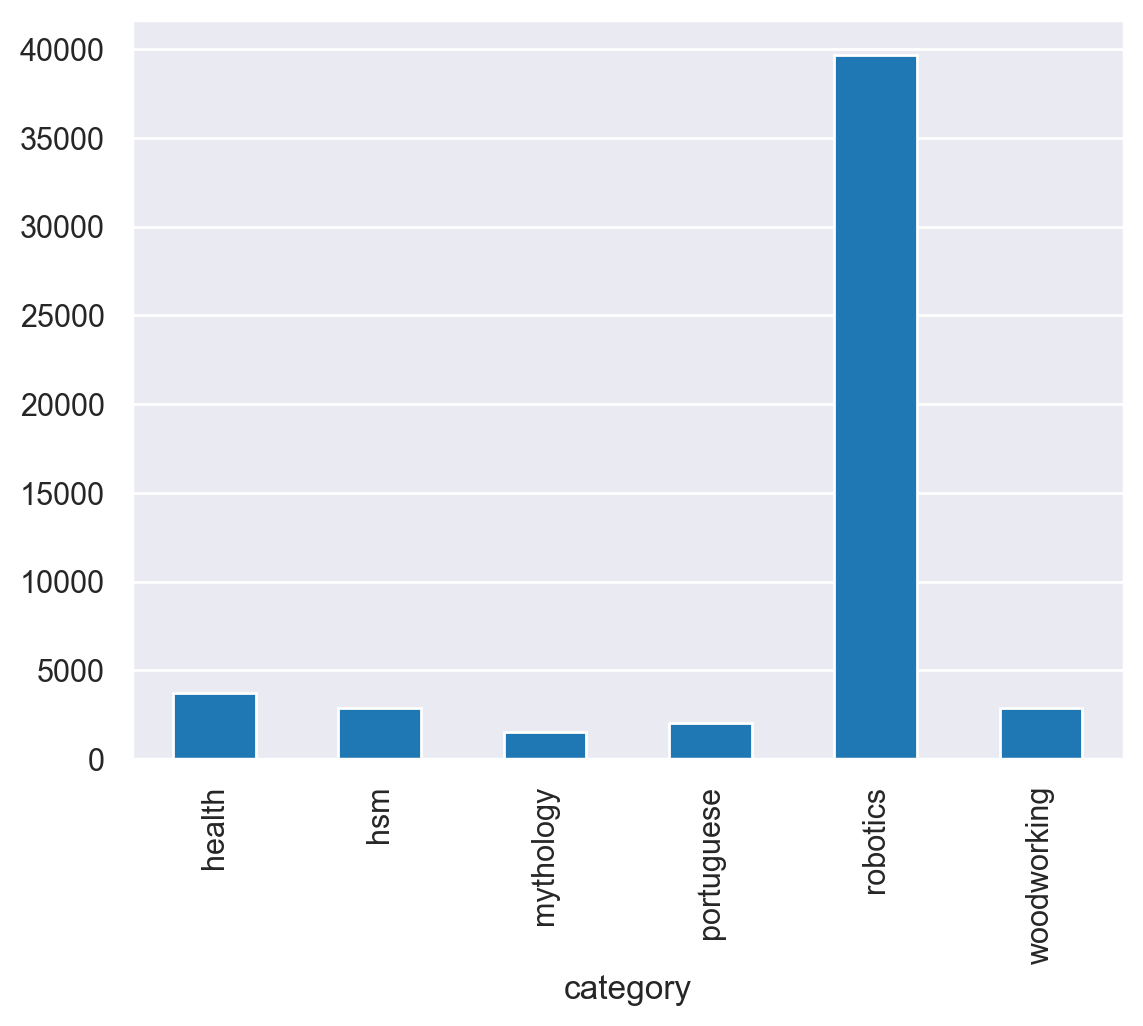

In [24]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [26]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} =
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [27]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus).toarray()

tfidf_df = pd.DataFrame(tfidf_matrix, index=corpus, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [28]:
ys = all_df.cat_id.values

In [29]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

In [30]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (52682, 5000)
ys.shape = (52682,)


In [32]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

In [39]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

nb_classifier = MultinomialNB()
nb_classifier.fit(train_xs, train_ys)

predictions = nb_classifier.predict(test_xs)

print("CountVectorizer classification report")
print(classification_report(test_ys, predictions))

CountVectorizer classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       433
           1       0.92      0.99      0.96       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.98      0.95       853
           4       0.96      0.99      0.97      1117
           5       1.00      0.93      0.96       636

    accuracy                           0.99     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.99      0.99     15805



In [38]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
xs = tfidf_vectorizer.fit_transform(all_df.text).toarray()

train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_xs, train_ys)
pred_tfidf = nb_tfidf.predict(test_xs)

print("\nTfidfVectorizer classification report")
print(classification_report(test_ys, pred_tfidf))


TfidfVectorizer classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       433
           1       0.92      0.99      0.96       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.98      0.95       853
           4       0.96      0.99      0.97      1117
           5       1.00      0.93      0.96       636

    accuracy                           0.99     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.99      0.99     15805



#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [40]:
nb_gaussian = GaussianNB()
nb_gaussian.fit(train_xs, train_ys)
pred_gaussian = nb_gaussian.predict(test_xs)

print("\nGaussianNB classification report")
print(classification_report(test_ys, pred_gaussian))



GaussianNB classification report
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       433
           1       0.96      0.94      0.95       879
           2       0.99      0.99      0.99     11887
           3       0.84      0.89      0.86       853
           4       0.94      0.93      0.94      1117
           5       1.00      0.96      0.98       636

    accuracy                           0.98     15805
   macro avg       0.94      0.93      0.93     15805
weighted avg       0.98      0.98      0.98     15805



MultinomialNB achieves 0.99 accuracy and GaussianNB achieves 0.98.

#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Translate this result into a sentence

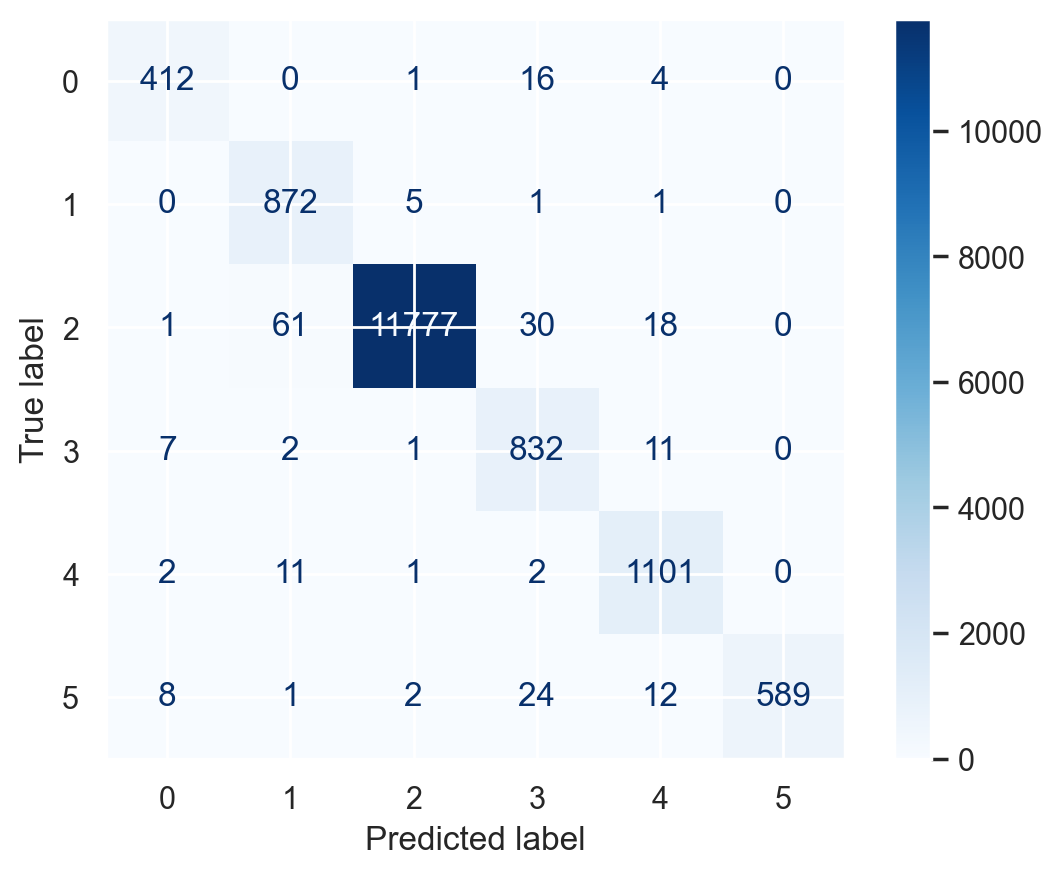

In [41]:
conf_matrix = confusion_matrix(test_ys, pred_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=nb_classifier.classes_)
disp.plot(cmap="Blues")

The confusion matrix gives a breakdown of the classifier's performance by showing:

True Positives (TP): Correctly classified instances of a specific class.

True Negatives (TN): Instances correctly classified as not belonging to a class.

False Positives (FP): Instances incorrectly classified as belonging to a class.

False Negatives (FN): Instances that belong to a class but were misclassified.

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [43]:
tfidf_vectorizer_no_stop = TfidfVectorizer(max_features=5000)
sparse_xs_no_stop = tfidf_vectorizer_no_stop.fit_transform(all_df.text)

tfidf_vectorizer_with_stop = TfidfVectorizer(max_features=5000, stop_words="english")
sparse_xs_with_stop = tfidf_vectorizer_with_stop.fit_transform(all_df.text)

print(f"Shape without stop words: {sparse_xs_no_stop.shape}")
print(f"Shape with stop words removed: {sparse_xs_with_stop.shape}")

train_xs_no_stop, test_xs_no_stop, train_ys, test_ys = train_test_split(
    sparse_xs_no_stop, ys, test_size=0.3, random_state=0, shuffle=True
)

train_xs_with_stop, test_xs_with_stop, _, _ = train_test_split(
    sparse_xs_with_stop, ys, test_size=0.3, random_state=0, shuffle=True
)

nb_no_stop = MultinomialNB()
nb_no_stop.fit(train_xs_no_stop, train_ys)
pred_no_stop = nb_no_stop.predict(test_xs_no_stop)

print("Classification report (no stop words removed)")
print(classification_report(test_ys, pred_no_stop))

nb_with_stop = MultinomialNB()
nb_with_stop.fit(train_xs_with_stop, train_ys)
pred_with_stop = nb_with_stop.predict(test_xs_with_stop)

print("\nClassification report (with stop words removed)")
print(classification_report(test_ys, pred_with_stop))

Shape without stop words: (52682, 5000)
Shape with stop words removed: (52682, 5000)
Classification report (no Stop words removed)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       433
           1       0.92      0.99      0.96       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.98      0.95       853
           4       0.96      0.99      0.97      1117
           5       1.00      0.93      0.96       636

    accuracy                           0.99     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.99      0.99     15805


Classification report (with stop words removed)
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       433
           1       0.92      0.99      0.96       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.97      0.95       853
      

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

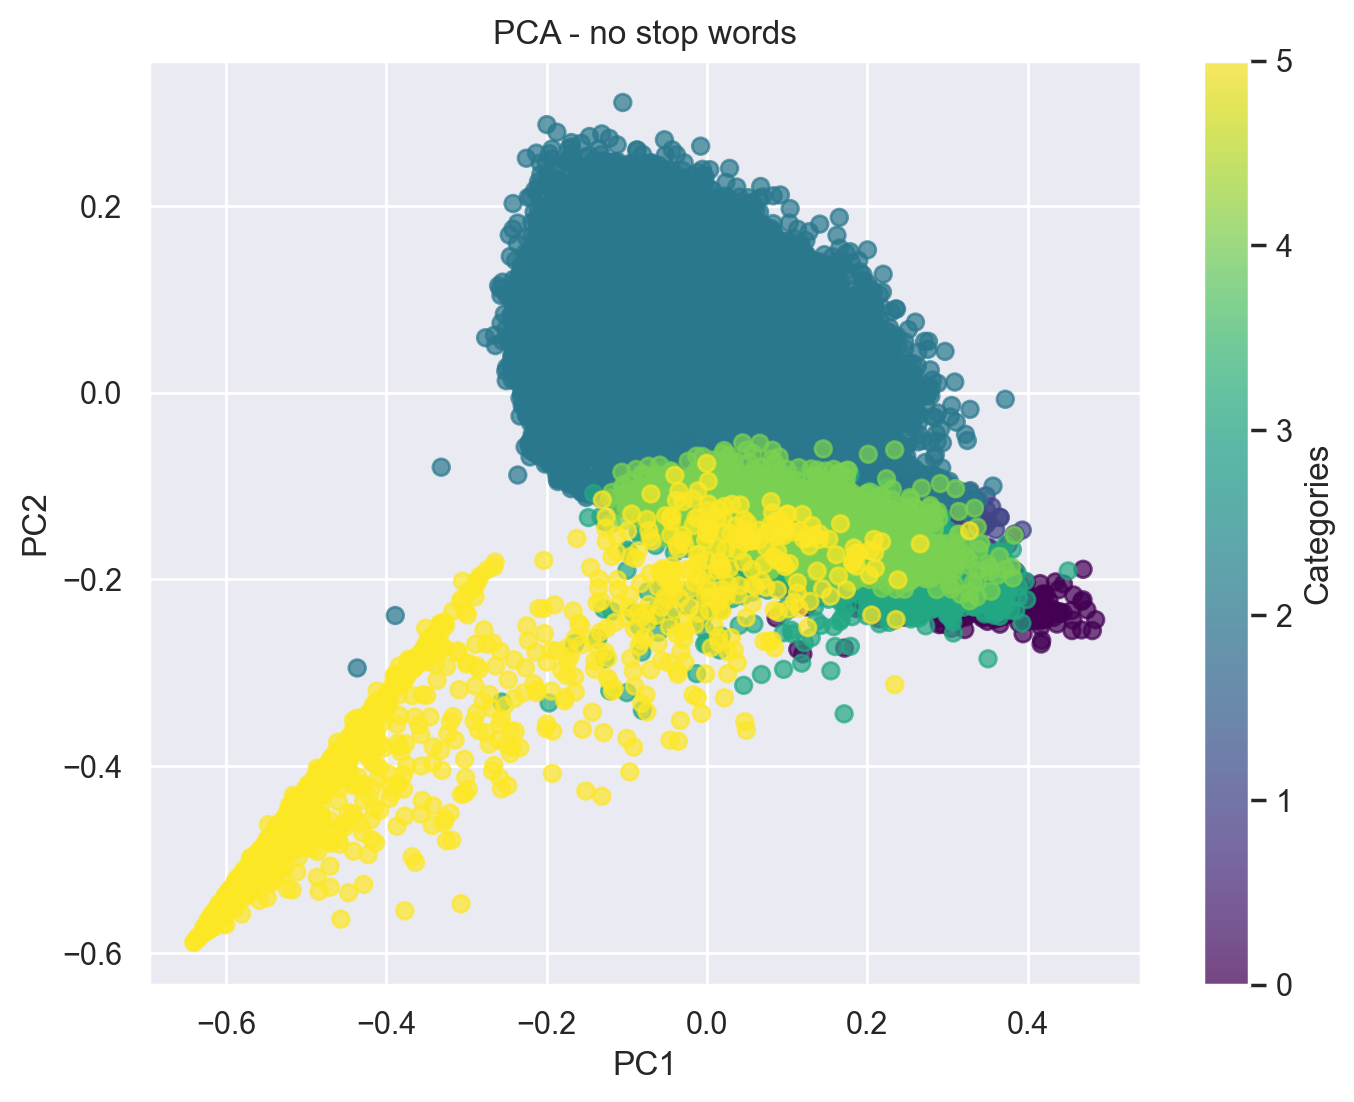

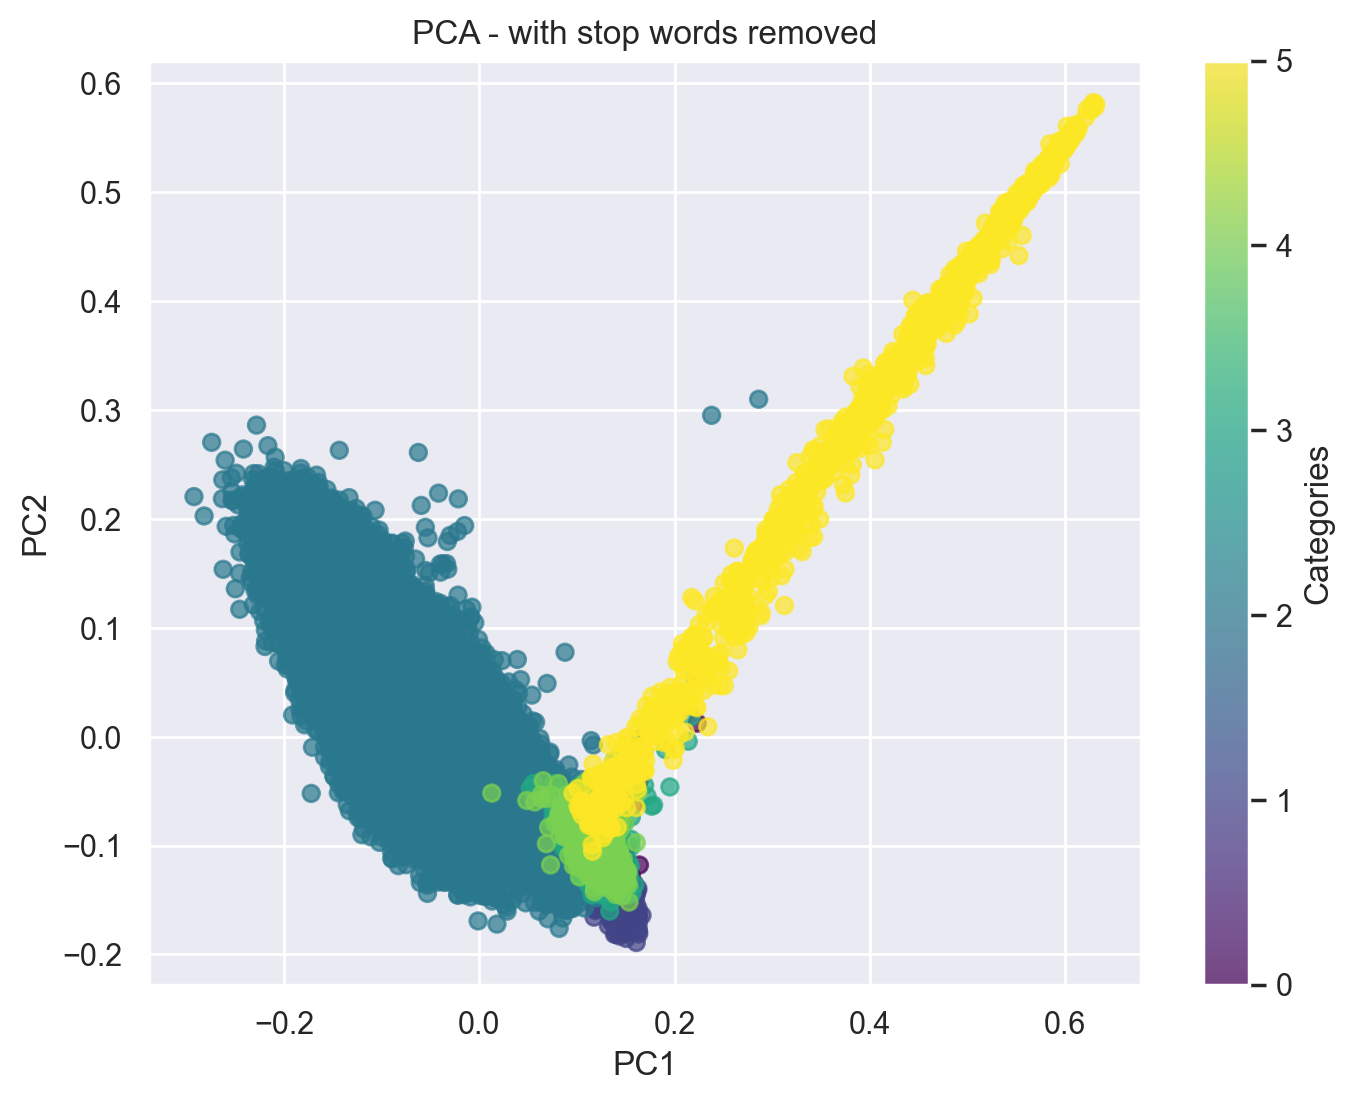

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_no_stop = pca.fit_transform(sparse_xs_no_stop.toarray())

pca_with_stop = pca.fit_transform(sparse_xs_with_stop.toarray())

train_xs_no_stop, test_xs_no_stop, train_ys, test_ys = train_test_split(
    pca_no_stop, ys, test_size=0.3, random_state=0, shuffle=True
)

train_xs_with_stop, test_xs_with_stop, _, _ = train_test_split(
    pca_with_stop, ys, test_size=0.3, random_state=0, shuffle=True
)

def plot_pca(pca_data, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        pca_data[:, 0], pca_data[:, 1], c=labels, cmap="viridis", alpha=0.7
    )
    plt.colorbar(scatter, label="Categories")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

plot_pca(pca_no_stop, ys, "PCA - no stop words")
plot_pca(pca_with_stop, ys, "PCA - with stop words removed")


#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

In [46]:
pca_train_with_stop = pca_with_stop.fit_transform(train_xs_with_stop)
pca_test_with_stop = pca_with_stop.transform(test_xs_with_stop)

In [47]:
pca_train_with_stop

array([[ 0.00722973, -0.03066317],
       [-0.12221136,  0.11523858],
       [ 0.12270616, -0.08457778],
       ...,
       [-0.05608424,  0.04085363],
       [-0.08073889,  0.17208785],
       [ 0.12735612, -0.1013957 ]], shape=(36877, 2))

In [48]:
pca_with_stop = PCA(n_components=2)
pca_train_with_stop = pca_with_stop.fit_transform(train_xs_with_stop)
pca_test_with_stop = pca_with_stop.transform(test_xs_with_stop)

pca_no_stop = PCA(n_components=2)
pca_train_no_stop = pca_no_stop.fit_transform(train_xs_no_stop)
pca_test_no_stop = pca_no_stop.transform(test_xs_no_stop)

# shift PCA values to make them non-negative (MultinomialNB doesn't work with negative values)
pca_train_with_stop += abs(pca_train_with_stop.min(axis=0))
pca_test_with_stop += abs(pca_test_with_stop.min(axis=0))
pca_train_no_stop += abs(pca_train_no_stop.min(axis=0))
pca_test_no_stop += abs(pca_test_no_stop.min(axis=0))


def train_and_evaluate(train_x, test_x, train_y, test_y, classifier, title):
    classifier.fit(train_x, train_y)
    predictions = classifier.predict(test_x)
    print(f"{title} classification report")
    print(classification_report(test_y, predictions))

print("PCA with wtop words:")
train_and_evaluate(
    pca_train_with_stop, pca_test_with_stop, train_ys, test_ys, MultinomialNB(), "MultinomialNB"
)
train_and_evaluate(
    pca_train_with_stop, pca_test_with_stop, train_ys, test_ys, GaussianNB(), "GaussianNB"
)

print("\nPCA without stop words:")
train_and_evaluate(
    pca_train_no_stop, pca_test_no_stop, train_ys, test_ys, MultinomialNB(), "MultinomialNB"
)
train_and_evaluate(
    pca_train_no_stop, pca_test_no_stop, train_ys, test_ys, GaussianNB(), "GaussianNB"
)

PCA with wtop words:
MultinomialNB classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.00      0.00      0.00       879
           2       0.75      1.00      0.86     11887
           3       0.00      0.00      0.00       853
           4       0.00      0.00      0.00      1117
           5       0.00      0.00      0.00       636

    accuracy                           0.75     15805
   macro avg       0.13      0.17      0.14     15805
weighted avg       0.57      0.75      0.65     15805

GaussianNB classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.72      0.42      0.53       879
           2       0.91      1.00      0.95     11887
           3       0.28      0.28      0.28       853
           4       0.42      0.34      0.38      1117
           5       1.00      0.89      0.9

/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

class NonNegativeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.min_ = X.min(axis=0)
        return self

    def transform(self, X):
        return X - self.min_


pipeline = Pipeline([
    ("pca", PCA()),
    ("non_negative", NonNegativeTransformer()),
    ("classifier", MultinomialNB())
])

param_grid = {
    "pca__n_components": [2, 5, 10, 20, 50, 100],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

train_xs, test_xs, train_ys, test_ys = train_test_split(
    sparse_xs_no_stop, ys, test_size=0.3, random_state=0, shuffle=True
)

grid_search.fit(train_xs, train_ys)

best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_xs)

print("Best number of PCA dimensions:", grid_search.best_params_)
print("\nClassification report on test set:")
print(classification_report(test_ys, test_predictions))

Best number of PCA dimensions: {'pca__n_components': 2}

Classification report on test set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       433
           1       0.00      0.00      0.00       879
           2       0.75      1.00      0.86     11887
           3       0.00      0.00      0.00       853
           4       0.00      0.00      0.00      1117
           5       0.00      0.00      0.00       636

    accuracy                           0.75     15805
   macro avg       0.13      0.17      0.14     15805
weighted avg       0.57      0.75      0.65     15805



/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

## N-grams features for text classification

*   We will use bigram in this section

In [49]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [53]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,00 00
1,000 000
2,000000 000000
3,001 001
4,01 01
...,...
4995,your system
4996,your time
4997,your urdf
4998,your workspace


In [54]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with bigrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

In [61]:
nb_bigrams = MultinomialNB()
nb_bigrams.fit(train_xs, train_ys)
pred_2g = nb_bigrams.predict(test_xs)

print("Classification report (bigrams):")
print(classification_report(test_ys, pred_2g))

vectorizer_unigram = CountVectorizer(max_features=5000)
x_unigrams = vectorizer_unigram.fit_transform(all_df.text).toarray()

train_xs_uni, test_xs_uni, train_ys, test_ys = train_test_split(
    x_unigrams, ys, test_size=0.3, random_state=0, shuffle=True
)

nb_unigrams = MultinomialNB()
nb_unigrams.fit(train_xs_uni, train_ys)
pred_uni = nb_unigrams.predict(test_xs_uni)

print("\nClassification report (unigrams):")
print(classification_report(test_ys, pred_uni))

Classification report (bigrams):
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       433
           1       0.92      0.99      0.96       879
           2       1.00      0.99      0.99     11887
           3       0.92      0.98      0.95       853
           4       0.96      0.99      0.97      1117
           5       1.00      0.93      0.96       636

    accuracy                           0.99     15805
   macro avg       0.96      0.97      0.96     15805
weighted avg       0.99      0.99      0.99     15805


Classification report (unigrams):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       433
           1       0.82      1.00      0.90       879
           2       1.00      0.97      0.98     11887
           3       0.85      0.96      0.90       853
           4       0.93      0.98      0.96      1117
           5       1.00      0.90      0.95       636

    accur

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [55]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [56]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [57]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [58]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

,freq
is,7
his,4
thi,3
is,3
s i,2
s c,1
co,1


### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [62]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

,text,category,cat_id
id,,,
woodworking.stackexchange_0000009758,Q:\n\nIs support on three sides of a long popl...,woodworking,1
woodworking.stackexchange_0000005965,Q:\n\nHow would I go about recreating this sur...,woodworking,1
woodworking.stackexchange_0000001325,Q:\n\nWhat is this type of screw from a piece ...,woodworking,1
woodworking.stackexchange_0000009884,Q:\n\nSafe to make a cable organisation box ou...,woodworking,1
woodworking.stackexchange_0000002552,Q:\n\nDesign for wall-hanging knife holder\n\n...,woodworking,1


In [63]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

Is support on three sides of a long poplar bookshelf enough?

I'm hoping to install a 94" wide, 8" deep, 1/2" thick bookshelf made of poplar in a location surrounded by three walls.
Thanks to the three walls, it would be painless to support the shelf on boards attached to studs at both ends, and along the full length of the rea


In [65]:
import nltk
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt')

wood_text = " ".join(wood_df.text)
tokens = word_tokenize(wood_text)
normalized_tokens = [token.lower() for token in tokens]

n = 2
bigrams = list(ngrams(normalized_tokens, n))
ngram_freq = Counter(bigrams)
print("Most common bigrams:")
for bigram, freq in ngram_freq.most_common(10):
    print(f"{bigram}: {freq}")

[nltk_data] Downloading package punkt to /home/petko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most common bigrams:
('of', 'the'): 8858
('.', 'i'): 6315
(',', 'and'): 4982
(',', 'but'): 4808
('in', 'the'): 4441
('.', 'the'): 4223
('a', ':'): 4110
('on', 'the'): 3916
('to', 'the'): 3751
('it', "'s"): 3743


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

In [67]:
import numpy as np

total_bigrams = sum(ngram_freq.values())
bigram_probs = {bigram: freq / total_bigrams for bigram, freq in ngram_freq.items()}

bigram_dict = {}
for (w1, w2), prob in bigram_probs.items():
    if w1 not in bigram_dict:
        bigram_dict[w1] = []
    bigram_dict[w1].append((w2, prob))

for w1, next_words in bigram_dict.items():
    total_prob = sum(prob for _, prob in next_words)
    bigram_dict[w1] = [(w2, prob / total_prob) for w2, prob in next_words]

def generate_text(start_word, bigram_dict, max_words=50):
    rng = np.random.default_rng()
    current_word = start_word
    text = [current_word]

    for _ in range(max_words):
        if current_word not in bigram_dict:
            break
        next_words, probs = zip(*bigram_dict[current_word])
        current_word = rng.choice(next_words, p=probs)
        text.append(current_word)
        if current_word == ".":
            break

    return " ".join(text)

starting_words = ["woodworking", "tools", "project", "cut"]

for word in starting_words:
    print(f"Generated text starting with '{word}':")
    print(generate_text(word, bigram_dict))
    print("-" * 50)

Generated text starting with 'woodworking':
woodworking tools can use solid piece of the bit of the middle partition .
--------------------------------------------------
Generated text starting with 'tools':
tools one shown in service life by some depth of trim such as it up a truck bed .
--------------------------------------------------
Generated text starting with 'project':
project using mounting on the specifics of the pin '' ) , where you might vary depending on highland woodworking tasks .
--------------------------------------------------
Generated text starting with 'cut':
cut the age '' is of resolution image from narrower than a wooden case with a month long ... after a burr outside shafts , laminating .
--------------------------------------------------


### TODO (optional): Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

In [68]:
def filter_domain(df, category):
    return " ".join(df[df.category == category].text)

def process_corpus(text):
    tokens = word_tokenize(text)
    normalized_tokens = [token.lower() for token in tokens]
    bigrams = list(ngrams(normalized_tokens, 2))
    bigram_freq = Counter(bigrams)
    total_bigrams = sum(bigram_freq.values())
    bigram_probs = {bigram: freq / total_bigrams for bigram, freq in bigram_freq.items()}

    bigram_dict = {}
    for (w1, w2), prob in bigram_probs.items():
        if w1 not in bigram_dict:
            bigram_dict[w1] = []
        bigram_dict[w1].append((w2, prob))

    for w1, next_words in bigram_dict.items():
        total_prob = sum(prob for _, prob in next_words)
        bigram_dict[w1] = [(w2, prob / total_prob) for w2, prob in next_words]

    return bigram_dict

def generate_text(start_word, bigram_dict, max_words=50):
    rng = np.random.default_rng()
    current_word = start_word.lower()
    text = [current_word.capitalize()]

    for _ in range(max_words):
        if current_word not in bigram_dict:
            break
        next_words, probs = zip(*bigram_dict[current_word])
        try:
            current_word = rng.choice(next_words, p=probs)
        except ValueError:
            break
        if current_word in [".", ",", "!", "?"]:
            text[-1] += current_word
        else:
            text.append(current_word)
        if current_word == ".":
            break

    return " ".join(text)

categories = ["woodworking", "mythology"]
for category in categories:
    print(f"\nText generation for category: {category}")
    domain_text = filter_domain(all_df, category)
    bigram_dict = process_corpus(domain_text)

    starting_words = ["woodworking", "tools", "gods", "myth"]
    for word in starting_words:
        print(f"Generated text starting with '{word}':")
        try:
            print(generate_text(word, bigram_dict))
        except KeyError:
            print(f"No bigrams found for the word '{word}'.")
        print("-" * 50)


Text generation for category: woodworking
Generated text starting with 'woodworking':
Woodworking business.
--------------------------------------------------
Generated text starting with 'tools':
Tools that make a go in north texas elements year to find.
--------------------------------------------------
Generated text starting with 'gods':
Gods
--------------------------------------------------
Generated text starting with 'myth':
Myth when you decant a very small enough wood, if you can be my second plane ever get to see that along.
--------------------------------------------------

Text generation for category: mythology
Generated text starting with 'woodworking':
Woodworking
--------------------------------------------------
Generated text starting with 'tools':
Tools : most often shown to be leviticus 26.21-26,33 if you are in the world : the myth.
--------------------------------------------------
Generated text starting with 'gods':
Gods : one of folds of all together everyth

---